In [2]:
import numpy as np
import pandas as pd
# import scikit-learn 
import matplotlib.pyplot as plt
import scipy.linalg

In [3]:
data = pd.read_csv("fukushima_wind.csv")

In [3]:
data.head()

,U10,V10
0,141.750000,141.750000
1,37.500000,37.500000
2,7.866323,-3.137803
3,6.886556,-4.111495
4,6.312439,-3.972887


In [4]:
df = np.array(data)[2:]

In [5]:
df_ = np.sqrt(df[:,1]**2+df[:,0]**2)

In [6]:
df_

array([8.46905258, 8.02053892, 7.45860007, ..., 6.94131682, 8.22693747,
       5.26589467])

In [7]:
df_ = np.where(df_<=2.72,0,df_)
df_ = np.where((df_ >= 2.72) & (df_ <= 8.15),1,df_)
df_ = np.where((df_ >= 8.15)&(df_ <=10),2,df_)
df_ = np.where((df_ >= 10)&(df_ <= 16.98),3,df_)
df_ = np.where(df_ >16.98,4,df_)

In [8]:
df_.astype(int)

array([2, 1, 1, ..., 1, 2, 1])

In [9]:
markov = np.zeros(25)

In [10]:
markov = markov.reshape(5,5)

In [11]:
markov

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [12]:
for i in range(df_.shape[0]-1):
    x = int(df_[i])
    y = int(df_[i+1])
    markov[x][y] += 1

In [13]:
markov

array([[2.2670e+03, 3.8480e+03, 1.3500e+02, 6.5000e+01, 1.0000e+00],
       [3.9440e+03, 2.3534e+04, 2.5690e+03, 1.3930e+03, 1.4000e+01],
       [8.0000e+01, 2.8950e+03, 1.8710e+03, 1.5030e+03, 1.4000e+01],
       [2.5000e+01, 1.1700e+03, 1.7710e+03, 5.3530e+03, 1.9400e+02],
       [0.0000e+00, 8.0000e+00, 1.6000e+01, 1.9900e+02, 8.6000e+01]])

In [14]:
markov_ = (markov.T/np.sum(markov,axis = 1)).T

In [15]:
np.sum(markov,axis = 1)

array([ 6316., 31454.,  6363.,  8513.,   309.])

In [16]:
markov_

array([[3.58929702e-01, 6.09246358e-01, 2.13742875e-02, 1.02913236e-02,
        1.58328056e-04],
       [1.25389458e-01, 7.48203726e-01, 8.16748267e-02, 4.42868951e-02,
        4.45094424e-04],
       [1.25726858e-02, 4.54974069e-01, 2.94043690e-01, 2.36209335e-01,
        2.20022002e-03],
       [2.93668507e-03, 1.37436861e-01, 2.08034770e-01, 6.28803007e-01,
        2.27886761e-02],
       [0.00000000e+00, 2.58899676e-02, 5.17799353e-02, 6.44012945e-01,
        2.78317152e-01]])

/Users/hiratatoumu/.pyenv/versions/3.5.1/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


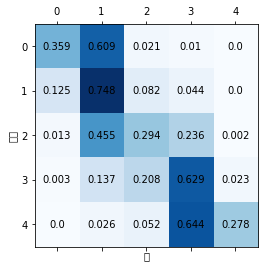

In [17]:
plt.matshow(markov_,cmap = plt.cm.Blues)
for i in range(markov_.shape[0]):
    for j in range(markov_.shape[1]):
        plt.text(x=j, y=i, s=round(markov_[i, j]*1000)/1000, va='center', ha='center')

plt.xlabel('次')
plt.ylabel('現在')

plt.tight_layout()
plt.show()

## 海洋戦略の最適化

条件
- 36yen/kwh
- 風力発電0.5yearたったら点検まで動けない
- 発電機は0.2/基/yで発生
- 修理は6-18時の状態1~3でのみできる
- 1基の点検には36時間かかる
- 修理には120時間かかる
- 作業船は現地から3時間かかる。
- 運行するかには天気予報は使えない（現在の天気のみ）
- 作業船は一隻2×10^8円かかり償却費2×10^7円　運転費は10^6円/24hかかる
- 事業期間は20year
- 発電機は200個
- 天気はmarkov_に従う(6hごとの遷移）
- 運転費は港ではかからない

最適化するもの  
`S = Σw*δ　- 2×10^8t - 20×2×10^7t - (10^6/24)×Σc`
```
w = [0,1900,5000,5000,0]
t .. 船の個数
c .. 運転時間
δ　.. 動けるかどうか
```

**使用ツール**


markov_をなるべく連続に  
c のルールを定めて実装＆最適化

In [18]:
wind_3 = scipy.linalg.sqrtm(markov_)

In [25]:
wind_3_plus = np.where(wind_3<0,0,wind_3)

In [26]:
wind_3_plus = (wind_3_plus.T/np.sum(wind_3_plus,axis = 1)).T

In [27]:
np.sum(wind_3_plus,axis = 1)

array([1., 1., 1., 1., 1.])

In [28]:
 wind_3_csv = pd.DataFrame(wind_3_plus)

In [29]:
wind_3_csv.to_csv("wind_markov.csv")